# Trigonometric model selection

This notebook will cover a model selection process for the trigonometric kernel. Every trigonometric function can be written as

\begin{equation*}
	f(x) = c_0 + \sum_{t=1}^{\infty}\left(c_t\cdot\cos(2\pi tx)+d_t\cdot\sin(2\pi tx)  \right)
\end{equation*}

where 

In [1]:
import numpy as np
import scipy as sp
import GPy
import kernels
import functions
from matplotlib import pyplot as plt

In [42]:
#Random State
rng = np.random.default_rng(420)

#Length of trig. polynomial
length = rng.integers(low=1, high=16, size=1)

#Coeff. in [-1, 1] and integer frequencies in [1, 10]
coeff = 2 * rng.random((2, length[0])) - 1
int_freq = rng.integers(low=1, high=10, size=length[0])
front_coeff = 2 * rng.random((1,)) - 1

def trig_poly(x):
    temp = front_coeff
    for i in range(0, length[0]):
        temp = temp + (coeff[0][i] * np.cos(2*np.pi*int_freq[i]*x) + coeff[1][i] * np.cos(2*np.pi*int_freq[i]*x))
    return temp

print(int_freq)

[7 2 4 8 6 4 1 4 8 5]


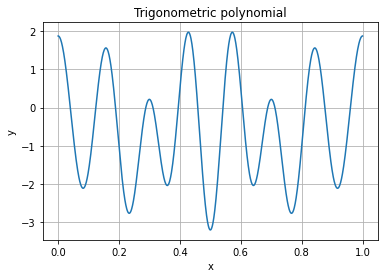

In [25]:
X = np.linspace(0, 1, 1000)
Y = trig_poly(X)
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trigonometric polynomial')
plt.grid()
plt.plot(X, Y)
plt.show()

In [26]:
b = np.linspace(0.01, 0.99, 99)
integralvalues = np.zeros((6, len(b)))
varvalues = np.zeros((6, len(b)))
abs_err = np.zeros((6, len(b)))
rel_err = np.zeros((6, len(b)))
I_trig_poly = sp.integrate.quad(trig_poly, a=0, b=1, epsabs=1.49e-16)[0]

In [32]:
for k in range(2, 8):
    for i in range(0, len(b)):
        TrigKern = kernels.Trigonometric(input_dim=1, weight=b[i])
        GPQ = functions.GPQ(f=trig_poly, kernel=TrigKern, A=np.array([0, 1]), NoN=k, return_var=True)
        integralvalues[k-2][i] = GPQ[0]
        varvalues[k-2][i] = GPQ[1]
        abs_err[k-2][i] = np.absolute(integralvalues[k-2][i] - I_trig_poly)
        rel_err[k-2][i] = abs_err[k-2][i] / np.absolute(I_trig_poly)

In [41]:
best_rel = np.zeros(6)
for k in range(2, 8):
    best_rel[k-2] = (np.argmin(rel_err[k-2]) + 1) / 100
print(best_rel)

[0.69 0.81 0.01 0.26 0.06 0.15]


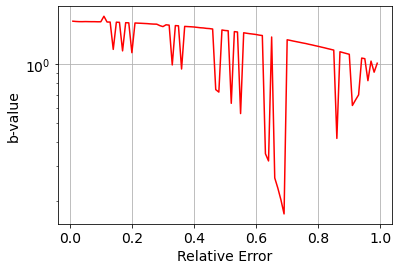

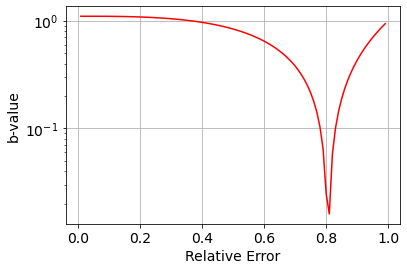

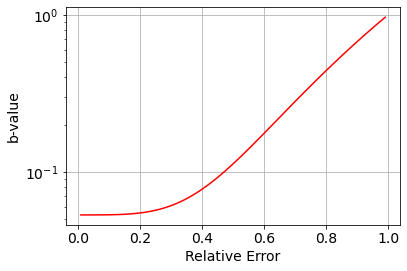

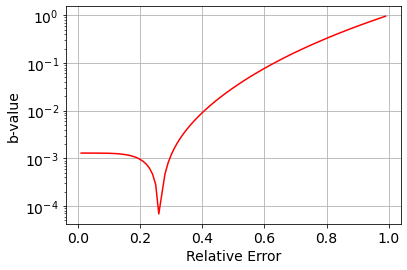

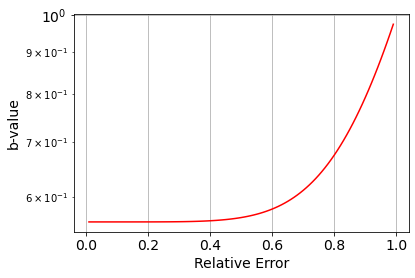

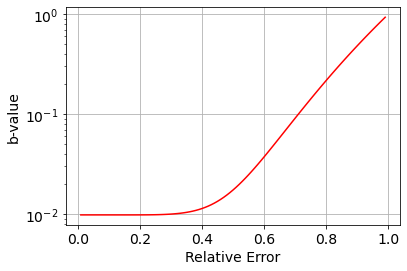

In [39]:
for k in range(2, 8):
    plt.figure()
    plt.grid()
    plt.plot(b, rel_err[k-2], 'r')
    plt.yscale('log')
    plt.ylabel('b-value',fontsize=14)
    plt.xlabel('Relative Error', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

# More samples

We will now have a look at some more samples with the same integer frequency.

## Frequency of t=3

In [66]:
b = np.linspace(0.01, 0.99, 99)
NoF_3 = 100
I_3 = np.zeros(NoF_3)
int_value_3 = np.zeros((6, NoF_3, len(b)))
abs_err_3 = np.zeros((6, NoF_3, len(b)))
rel_err_3 = np.zeros((6, NoF_3, len(b)))

In [67]:
for k in range(2, 8):
    for t in range(0, NoF_3):
        rng = np.random.default_rng(t)
        length = rng.integers(low=1, high=10, size=1)
        coeff = 2 * rng.random((2, length[0])) - 1
        int_freq = rng.integers(low=3, high=4, size=length[0])
        front_coeff = 2 * rng.random((1,)) - 1
        def trig_poly(x):
            temp = front_coeff
            for i in range(0, length[0]):
                temp = temp + coeff[0][i] * np.cos(2*np.pi*int_freq[i]*x) + coeff[1][i] * np.cos(2*np.pi*int_freq[i]*x)
            return temp
        if k == 2: I_3[t] = sp.integrate.quad(trig_poly, a=0, b=1, epsabs=1.49e-16)[0]
        for i in range(0, len(b)):
            TrigKern = kernels.Trigonometric(input_dim=1, weight=b[i])
            int_value_3[k-2][t][i] = functions.GPQ(f=trig_poly, kernel=TrigKern, A=np.array([0, 1]), NoN=k, return_var=False)
            abs_err_3[k-2][t][i] = np.absolute(int_value_3[k-2][t][i] - I_3[t])
            rel_err_3[k-2][t][i] = abs_err_3[k-2][t][i] / np.absolute(I_3[t])

In [68]:
b_opt_rel_3 = np.zeros((6, NoF_3))
for k in range(2, 8):
    for t in range(0, NoF_3):
        b_opt_rel_3[k-2][t] = (np.argmin(rel_err_3[k-2][t]) + 1) / 100

In [72]:
b_vis_rel_3 = [b_opt_rel_3[0], b_opt_rel_3[1], b_opt_rel_3[2], b_opt_rel_3[3], b_opt_rel_3[4], b_opt_rel_3[5]]
pos = [2, 3, 4, 5, 6, 7]

best_b_3 = np.zeros(6)
for k in range(2, 8):
    median = np.median(sorted(b_opt_rel_3[k-2]))
    mean = np.mean(sorted(b_opt_rel_3[k-2]))
    best_b_3[k-2] = np.round((median + mean) / 2, decimals=2)

array([0.01, 0.37, 0.07, 0.09, 0.12, 0.02])

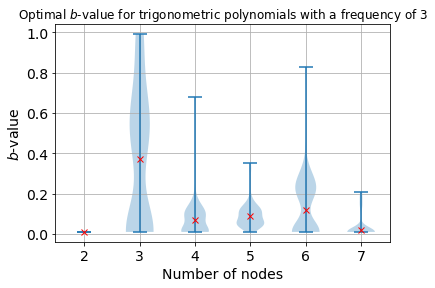

In [77]:
plt.figure()
plt.grid()
plt.violinplot(b_vis_rel_3, positions=pos)
plt.plot(pos, best_b_3, 'rx')
plt.ylabel('$b$-value', fontsize=14)
plt.xlabel('Number of nodes', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Optimal $b$-value for trigonometric polynomials with a frequency of 3')
plt.show()

In [86]:
b_vis_rel_3

[array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01]),
 array([0.01, 0.01, 0.56, 0.6 , 0.8 , 0.4 , 0.46, 0.01, 0.01, 0.85, 0.01,
        0.51, 0.01, 0.99, 0.99, 0.01, 0.63, 0.01, 0.01, 0.01, 0.01, 0.45,
        0.54, 0.01, 0.01, 0.6 , 0.54, 0.01, 0.58, 0.57, 0.68, 0.53, 0.66,
        0.01, 0.01, 0.01, 0.49, 0.01, 0.97, 0.38, 0.38, 0.81, 0.01, 0.45,
        0.59, 0.73, 0.

## Frequency of t=1

In [80]:
b = np.linspace(0.01, 0.99, 99)
NoF_1 = 100
I_1 = np.zeros(NoF_3)
int_value_1 = np.zeros((6, NoF_1, len(b)))
abs_err_1 = np.zeros((6, NoF_1, len(b)))
rel_err_1 = np.zeros((6, NoF_1, len(b)))

n_1 = 10

In [81]:
for k in range(2, 8):
    for t in range(0, NoF_1):
        rng = np.random.default_rng(t)
        length = rng.integers(low=1, high=n_1, size=1)
        coeff = 2 * rng.random((2, length[0])) - 1
        int_freq = rng.integers(low=3, high=4, size=length[0])
        front_coeff = 2 * rng.random((1,)) - 1
        def trig_poly(x):
            temp = front_coeff
            for i in range(0, length[0]):
                temp = temp + coeff[0][i] * np.cos(2*np.pi*int_freq[i]*x) + coeff[1][i] * np.cos(2*np.pi*int_freq[i]*x)
            return temp
        if k == 2: I_1[t] = sp.integrate.quad(trig_poly, a=0, b=1, epsabs=1.49e-16)[0]
        for i in range(0, len(b)):
            TrigKern = kernels.Trigonometric(input_dim=1, weight=b[i])
            int_value_1[k-2][t][i] = functions.GPQ(f=trig_poly, kernel=TrigKern, A=np.array([0, 1]), NoN=k, return_var=False)
            abs_err_1[k-2][t][i] = np.absolute(int_value_1[k-2][t][i] - I_1[t])
            rel_err_1[k-2][t][i] = abs_err_1[k-2][t][i] / np.absolute(I_1[t])

In [82]:
b_opt_rel_1 = np.zeros((6, NoF_1))
for k in range(2, 8):
    for t in range(0, NoF_1):
        b_opt_rel_1[k-2][t] = (np.argmin(rel_err_1[k-2][t]) + 1) / 100

In [83]:
b_vis_rel_1 = [b_opt_rel_1[0], b_opt_rel_1[1], b_opt_rel_1[2], b_opt_rel_1[3], b_opt_rel_1[4], b_opt_rel_1[5]]
pos = [2, 3, 4, 5, 6, 7]

best_b_1 = np.zeros(6)
for k in range(2, 8):
    median = np.median(sorted(b_opt_rel_1[k-2]))
    mean = np.mean(sorted(b_opt_rel_1[k-2]))
    best_b_1[k-2] = np.round((median + mean) / 2, decimals=2)

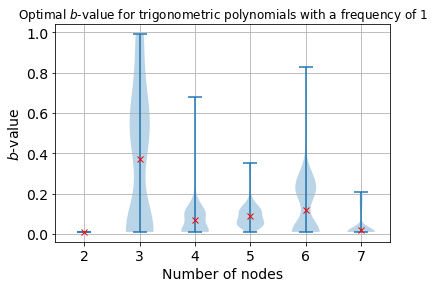

In [85]:
plt.figure()
plt.grid()
plt.violinplot(b_vis_rel_1, positions=pos)
plt.plot(pos, best_b_1, 'rx')
plt.ylabel('$b$-value', fontsize=14)
plt.xlabel('Number of nodes', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Optimal $b$-value for trigonometric polynomials with a frequency of 1')
plt.show()

In [87]:
b_vis_rel_1

[array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01]),
 array([0.01, 0.01, 0.56, 0.6 , 0.8 , 0.4 , 0.46, 0.01, 0.01, 0.85, 0.01,
        0.51, 0.01, 0.99, 0.99, 0.01, 0.63, 0.01, 0.01, 0.01, 0.01, 0.45,
        0.54, 0.01, 0.01, 0.6 , 0.54, 0.01, 0.58, 0.57, 0.68, 0.53, 0.66,
        0.01, 0.01, 0.01, 0.49, 0.01, 0.97, 0.38, 0.38, 0.81, 0.01, 0.45,
        0.59, 0.73, 0.

## Frequency t=10

In [ ]:
b = np.linspace(0.01, 0.99, 99)
NoF_10 = 100
I_10 = np.zeros(NoF_10)
int_value_10 = np.zeros((6, NoF_10, len(b)))
abs_err_10 = np.zeros((6, NoF_10, len(b)))
rel_err_10 = np.zeros((6, NoF_10, len(b)))

n_1 = 10